#Notebook 1: Creation of the Train Set

To develop an **effective object detection dataset** for images of home plants, I leveraged Microsoft's Florence-2-large model for precise labeling. The dataset was refined by normalizing bounding box coordinates. The data was then carefully split into training and validation sets to optimize model performance. My goal is to build a recognition model capable of identifying **10 different plant species**.

### Imports and definitions

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
import os
from google.colab import drive
import random
import zipfile
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import yaml
from sklearn.model_selection import train_test_split
import shutil
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import random
import time

custom_palette = [
    '#FF6F61',  # Coral Red
    '#FFA500',  # Bright Orange
    '#FFD700',  # Tropical Yellow
    '#32CD32',  # Lime Green
    '#20B2AA',  # Light Sea Green
    '#1E90FF',  # Dodger Blue
    '#6A5ACD',  # Slate Blue
    '#FF1493',  # Deep Pink
    '#FF4500',  # Orange Red
    '#2E8B57'   # Sea Green
]

In [ ]:
!pip install flash_attn einops timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash_attn: filename=flash_attn-2.7.2.post1-cp310-cp310-linux_x86_64.whl size=190160474 sha256=0b454d9e650bfc437cc71335080172a5d05f51eab355636c9d5b7321fec7318e
  Stored in directory: /root/.cache/pip/wheels/da/ec/5b/b2c37a8e4f755ad82492a822463bca0817f0e0e11de874b550
Successfully built flash_attn


In [ ]:
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/Plants Recognition/Model/' # Set your google drive path here

Mounted at /content/drive


In [ ]:
# Define paths for train and valid
IMAGES_PATH = os.path.join(BASE_PATH, 'plants_dataset')
TRAIN_IMAGES_PATH = os.path.join(BASE_PATH, 'dataset/images/train')
VAL_IMAGES_PATH = os.path.join(BASE_PATH, 'dataset/images/val')
TRAIN_LABELS_PATH = os.path.join(BASE_PATH, 'dataset/labels/train')
VAL_LABELS_PATH = os.path.join(BASE_PATH, 'dataset/labels/val')

# Create directories if they don't exist
os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok=True)
os.makedirs(VAL_IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_LABELS_PATH, exist_ok=True)
os.makedirs(VAL_LABELS_PATH, exist_ok=True)

##Microsoft's Florence-2-large

An advanced natural language processing model designed for a wide range of tasks, including text generation and image captioning. The output of its object detector tool is a set of bounding boxes that enclose the objects in the image, along with class labels and confidence scores for each box. In this project, we decided to exclude the confidence scores due to concerns about complexity and reliability issues.

In [ ]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, token=False).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True, token=False)

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def florence(task_prompt, image):
    prompt = task_prompt
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    return parsed_answer

##Example: Florence Usage
The goal is to **identify key terms** related to plants such as: **flower**, **plant**, **houseplant** etc.
This is essential for creating an effective recognition system that can distinguish between different plant species, including scenarios where multiple instances of the same plant species are present.

In [ ]:
image_url = 'https://cdn.shopify.com/s/files/1/0043/3628/7813/files/tradescantia-nanouk-stem-propagation_480x480.jpg?v=1703642938'
!wget -O tradescantia.jpg "{image_url}" -q

Labels: ['houseplant', 'person', 'vase']


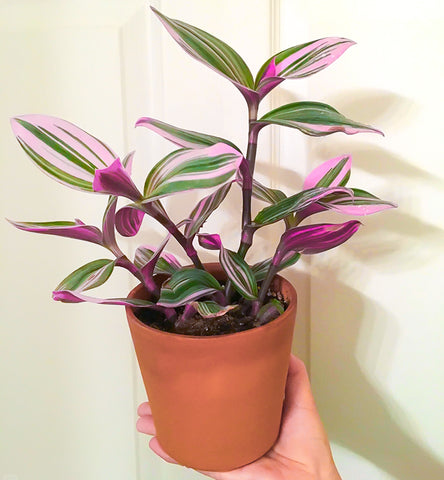

In [ ]:
image_path = 'tradescantia.jpg'
image = Image.open(image_path)

task_prompt = '<OD>'
result_text = florence(task_prompt, image)
results = result_text['<OD>']['labels']
print("Labels: " + str(results))

image

##Building the Dataset with Florence-2-large

I am constructing a dataset of images and labels containing plant species using Microsoft's Florence-2-large tool. The implementation processes images in batches of 500 for resource efficiency, particularly due to the use of GPU.

For each plant:
1. Extract Bounding Boxes (Bbox) - For plant species, Bboxes indicate the precise location of each plant in the image.
2. Save with matching labels - These labels form the backbone of the dataset, enabling supervised training of recognition models.

Using these images and their corresponding labels, we then build the dataset.

In [ ]:
TARGET_LABELS = ['houseplant', 'plant', 'flower']
plants = [
    "Aloe Vera",
    "Tradescantia",
    "Snake plant (Sanseviera)",
    "Peace lily",
    "Orchid",
    "Monstera Deliciosa (Monstera deliciosa)",
    "Echeveria",
    "Ctenanthe",
    "Chinese Money Plant (Pilea peperomioides)",
    "African Violet (Saintpaulia ionantha)"
]

In [ ]:
image_paths = []
for plant in plants:
    plant_folder = os.path.join(IMAGES_PATH, plant)
    if os.path.exists(plant_folder):
        image_paths.extend([os.path.join(plant_folder, f) for f in os.listdir(plant_folder) if f.endswith('.jpg')])

In [ ]:
# Function to process images and generate labels, coordinates, and confidences
def classify_images_with_florence(image_paths, target_labels):
    results = []

    for file_path in image_paths:
        try:
            image = Image.open(file_path)
            task_prompt = '<OD>'
            result = florence(task_prompt, image)

            labels = result['<OD>']['labels']
            bboxes = result['<OD>']['bboxes']

            # Extract the plant name from the directory structure
            plant_name = os.path.basename(os.path.dirname(file_path))

            # Find the first bbox with a matching target label
            selected_bbox = None
            for label, bbox in zip(labels, bboxes):
                if label in target_labels:
                    selected_bbox = bbox
                    break

            if selected_bbox:
                results.append({
                    'image_path': file_path,
                    'plant_name': plant_name,
                    'bbox': selected_bbox
                })
            else:
                print(f"No target label found for image: {file_path}")

        except Exception as e:
            print(f"Error processing image {file_path}: {e}")

    return results

In [ ]:
results = classify_images_with_florence(image_paths, TARGET_LABELS)

Error processing image /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/plants_dataset/Peace lily/28.jpg: Unable to infer channel dimension format
No target label found for image: /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/plants_dataset/Monstera Deliciosa (Monstera deliciosa)/146.jpg
No target label found for image: /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/plants_dataset/Monstera Deliciosa (Monstera deliciosa)/171.jpg
No target label found for image: /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/plants_dataset/Monstera Deliciosa (Monstera deliciosa)/237.jpg
No target label found for image: /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/plants_dataset/Monstera Deliciosa (Monstera deliciosa)/273.jpg
No target label found for image: /content/drive/MyDrive/Studying/Computer Science - Final Project/Model/plants_dataset/Monstera Deliciosa (Monstera deliciosa)/537.

In [ ]:
# Process all files initially to gather all labels
data = pd.DataFrame(results)

# Create DataFrame for labels
dataset = pd.DataFrame({
    'image': data['image_path'],
    'label': data['plant_name'],
    'coordinates': data['bbox']
})


### Data cleaning

Cleaning and preprocessing the data is the most important step for the learning process of the model. In this case, it's crucial to deal with missing labels or coordinated since they are a great part of the model training process.

In [ ]:
dataset['label'] = dataset['label'].replace('None', None)
dataset['coordinates'] = dataset['coordinates'].replace('None', None)

In [ ]:
# Check for NaNs
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2779 entries, 0 to 2778
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        2779 non-null   object
 1   label        2779 non-null   object
 2   coordinates  2779 non-null   object
dtypes: object(3)
memory usage: 65.3+ KB


In [ ]:
cleaned_dataset = dataset.dropna().loc[(dataset['image'] != 'None') & (dataset['label'] != 'None') & dataset['coordinates'] != 'None']

###Normalize Bounding Boxes

Ensures that the coordinates of bounding boxes are scaled relative to the dimensions of the image. This process converts absolute pixel values into a range between 0 and 1, making the dataset consistent and compatible across different image sizes, crucial for training object detection models effectively.

In [ ]:
# Function to normalize a single bounding box using the image size
def normalize_single_bbox(bbox, image_size):
    x_min, y_min, x_max, y_max = bbox
    img_width, img_height = image_size
    x_center = ((x_min + x_max) / 2) / img_width
    y_center = ((y_min + y_max) / 2) / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return [x_center, y_center, width, height]

# Function to normalize all bounding boxes in a list
def normalize_bboxes(bboxes, image_size):
    return [normalize_single_bbox(bbox, image_size) for bbox in bboxes]

# Normalize the coordinates column
def get_image_size(image_path):
    image = cv2.imread(image_path)
    return image.shape[1], image.shape[0]  # (width, height)

def normalize_row(row):
    image_path = os.path.join(IMAGES_PATH, row['image'])
    image_size = get_image_size(image_path)
    return normalize_single_bbox(row['coordinates'], image_size)

cleaned_dataset['coordinates'] = cleaned_dataset.apply(normalize_row, axis=1)

###Example: Bbox and label for a plant image

BBOX:  [524, 0, 1499, 999]
Label:  Aloe Vera


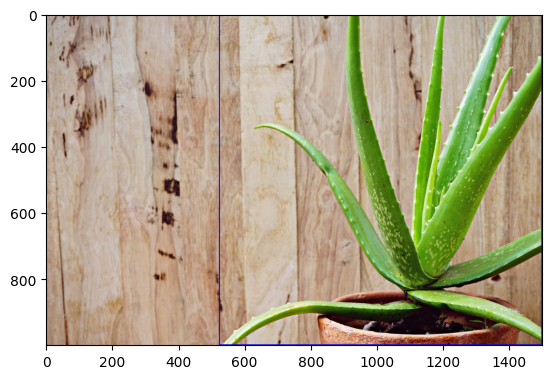

In [ ]:
# Function to denormalize the bounding box for visualization
def denormalize_single_bbox(bbox, image_size):
    x_center, y_center, width, height = bbox
    img_width, img_height = image_size
    x_min = int((x_center - width / 2) * img_width)
    y_min = int((y_center - height / 2) * img_height)
    x_max = int((x_center + width / 2) * img_width)
    y_max = int((y_center + height / 2) * img_height)
    return [x_min, y_min, x_max, y_max]

# Function to visualize an image with its bounding box
def visualize_bbox(image, bbox):
    x_min, y_min, x_max, y_max = bbox
    image_copy = image.copy()
    cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.show()

sample_index = 15
sample_label = dataset.loc[sample_index, 'label']
sample_image_path = cleaned_dataset.loc[sample_index, 'image']
sample_image_path = os.path.join(IMAGES_PATH, sample_image_path)
sample_image = cv2.imread(sample_image_path)

image_size = sample_image.shape[1], sample_image.shape[0]
sample_bbox = cleaned_dataset.loc[sample_index, 'coordinates']
denormalized_bbox = denormalize_single_bbox(sample_bbox, image_size)

print("BBOX: ", denormalized_bbox)
print("Label: ", sample_label)
visualize_bbox(sample_image, denormalized_bbox)

### Final count of images for each Plant (class)

In [ ]:
# Count the occurrences of each label
label_counts = cleaned_dataset['label'].value_counts()

# Data for plotting
labels = plants
counts = [label_counts.get(plant, 0) for plant in plants]
total_count = sum(counts)

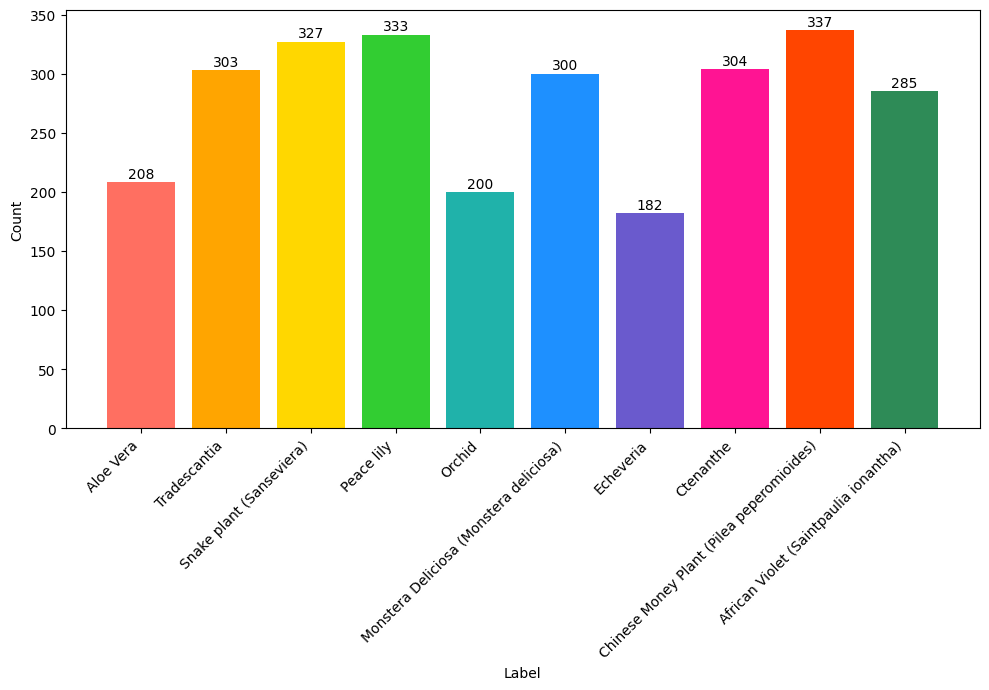

In [ ]:
# Visualize
fig, ax = plt.subplots(figsize=(10, 7))  # Increased figure size
ax.bar(labels, counts, color=custom_palette)

# Annotate each bar with its count
for i, count in enumerate(counts):
    ax.text(i, count + 1, str(count), ha='center', va='bottom')

# Adjust labels and axis
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Slight rotation for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

### Split to Train and Validation

In [ ]:
# Split dataset into training and validation sets
train_df, val_df = train_test_split(cleaned_dataset, test_size=0.2, stratify=dataset['label'], random_state=42)

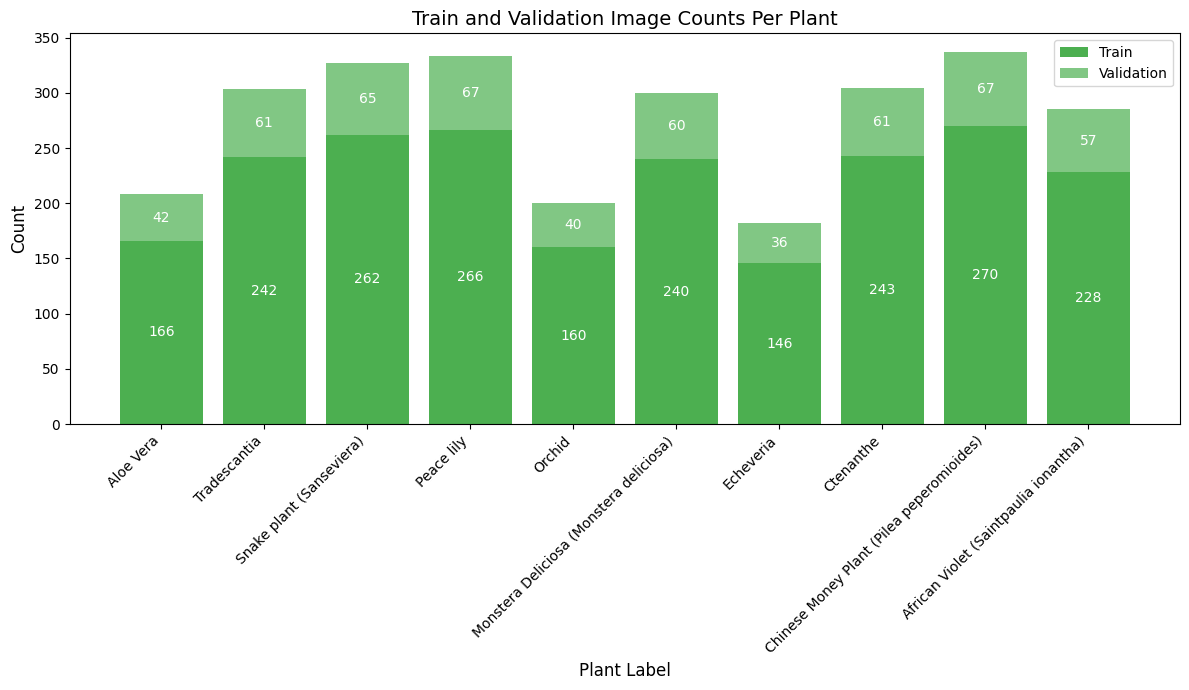

In [ ]:
# Visualization of training and validation counts per plant label
train_counts = train_df['label'].value_counts()
val_counts = val_df['label'].value_counts()

categories = plants
train_values = [train_counts.get(plant, 0) for plant in categories]
val_values = [val_counts.get(plant, 0) for plant in categories]

fig, ax = plt.subplots(figsize=(12, 7))  # Increased figure size
bars_train = ax.bar(categories, train_values, color='#4CAF50', label='Train')
bars_val = ax.bar(categories, val_values, bottom=train_values, color='#81C784', label='Validation')

# Add annotations for Train bars
for i, bar in enumerate(bars_train):
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, yval / 2, int(yval),
        ha='center', va='center', color='white', fontsize=10
    )

# Add annotations for Validation bars
for i, bar in enumerate(bars_val):
    yval = bar.get_height() + bars_train[i].get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, yval - bar.get_height() / 2, int(bar.get_height()),
        ha='center', va='center', color='white', fontsize=10
    )

# Adjust labels and axis
ax.set_xlabel('Plant Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Train and Validation Image Counts Per Plant', fontsize=14)
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right')  # Rotate x-axis labels
ax.legend(fontsize=10)

plt.tight_layout()  # Ensure everything fits within the figure
plt.show()


### Fill the Train and Validation directories

In [ ]:
# Create a dynamic mapping of plant names to class IDs
plant_classes = {plant: idx for idx, plant in enumerate(plants)}

In [ ]:
# Function to copy files to train and val directories
def copy_files_to_directories(filenames, labels, coordinates, image_dest, label_dest, plant_classes):
    for i, filename in enumerate(filenames):
        file_basename = os.path.basename(filename)  # Use only the basename
        file_path = os.path.join(IMAGES_PATH, filename)
        label = labels[i]
        coord = coordinates[i]

        # Assign a dynamic class ID based on the plant_classes dictionary
        class_id = plant_classes.get(label, -1)

        # Extract the file extension dynamically
        file_extension = os.path.splitext(file_basename)[1]

        # Update filenames to include class ID
        new_file_basename = f"{class_id}_{os.path.basename(filename)}"
        label_file_path = os.path.join(label_dest, new_file_basename.replace(file_extension, '.txt'))
        with open(label_file_path, 'w') as f:
            if coord:
                x_min, y_min, x_max, y_max = coord
                f.write(f'{class_id} {x_min} {y_min} {x_max} {y_max}')
            else:
                f.write(f'{class_id} 0.5 0.5 0.5 1 1')  # Dummy label in YOLO format

        dest_file_path = os.path.join(image_dest, new_file_basename)
        if os.path.abspath(file_path) != os.path.abspath(dest_file_path):
            image = Image.open(file_path)
            image.save(dest_file_path)


In [ ]:
# Function to count the number of files in a directory
def count_files_in_directory(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

In [ ]:
# Function to ensure all files are copied
def ensure_all_files_copied(filenames, image_dest, label_dest):
    expected_file_count = len(filenames)
    while True:
        image_file_count = count_files_in_directory(image_dest)
        label_file_count = count_files_in_directory(label_dest)
        if image_file_count == expected_file_count and label_file_count == expected_file_count:
            break
        time.sleep(1)  # Wait for 1 second before checking again
    print("All files copied successfully.")

In [ ]:
# Copy train files
train_images = train_df['image'].tolist()
train_labels = train_df['label'].tolist()
train_coordinates = train_df['coordinates'].tolist()
copy_files_to_directories(train_images, train_labels, train_coordinates, TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH, plant_classes)
ensure_all_files_copied(train_images, TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH)

All files copied successfully.


In [ ]:
# Copy val files
val_images = val_df['image'].tolist()
val_labels = val_df['label'].tolist()
val_coordinates = val_df['coordinates'].tolist()
copy_files_to_directories(val_images, val_labels, val_coordinates, VAL_IMAGES_PATH, VAL_LABELS_PATH, plant_classes)
ensure_all_files_copied(val_images, VAL_IMAGES_PATH, VAL_LABELS_PATH)

All files copied successfully.


# Sammury of the Train Set creation part

My goal was to create a model capable of recognizing 10 different plant species, including Echeveria and other popular houseplants. I started by gathering a dataset of plant images, with each one labeled to reflect its species. Using Microsoft's Florence-2-large, I identified the locations of plants within the images, ensuring that each one was accurately annotated. Once labeled, the dataset was organized and split into training and validation sets, setting the stage for building a reliable and efficient plant identification model.

### **Steps along the way**

**1 - Images**
* Images were collected from well-organized directories where each folder represented a specific plant species.
* Each image folder was named according to the plant species (e.g., Echeveria, Monstera).

**2 - Labeling Images with Florence-2-Large Model**
* Used Microsoft's Florence-2-large model to generate bounding box annotations for plant species in each image.
* The labels were directly assigned based on the folder names, aligning the bounding boxes with their respective plant species.

**3 - Building the Dataset**
* Labels were mapped directly from the folder structure.
* Bounding boxes were saved alongside the corresponding species labels for each image, creating a clean and structured dataset.

**4 - Cleaning the Data**
* Consistency and Correctness:
Bounding box coordinates were normalized to ensure compatibility with the YOLO model.

**5 - Data Segmentation**
* Data was split into training and validation sets based on folder contents, with no predefined minimums for each split.
* Organized datasets into the required YOLO directory structure:
  * dataset/images/train
  * dataset/images/val
  * dataset/labels/train
  * dataset/labels/val
  
### **Conclusions**
The creation of the training dataset involved careful preprocessing to ensure **high-quality data for model training**. Labeling accuracy, data cleaning, and proper segmentation were crucial in building a **reliable dataset**, setting a solid foundation for subsequent training and evaluation of the model.